<a href="https://colab.research.google.com/github/Willyzw/SuperPointPretrainedNetwork/blob/master/superpoint_handson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SuperGlue Handson
This demo

In [1]:
# ! git clone https://github.com/Willyzw/SuperGluePretrainedNetwork.git
# % cd /content/SuperGluePretrainedNetwork

# Network architecture
## Import modules 

In [2]:
import time
import matplotlib.cm as cm
import PIL.Image as pil
import torch

from IPython.display import clear_output
from models.matching import Matching
from models.utils import (AverageTimer, VideoStreamer, make_matching_plot_fast, frame2tensor)

torch.set_grad_enabled(False)

## Initialize module and helper I/O class

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Running inference on device \"{}\"'.format(device))
config = {
    'superpoint': {'nms_radius': 4, 'keypoint_threshold': 0.005, 'max_keypoints': -1},
    'superglue': {'weights': 'indoor', 'sinkhorn_iterations': 20, 'match_threshold': 0.2}
}
matching = Matching(config).eval().to(device)
keys = ['keypoints', 'scores', 'descriptors']

vs = VideoStreamer('assets/freiburg_sequence', resize=[640, 480], skip=1, image_glob=['*.png'], max_length=10000)

Running inference on device "cuda"
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
==> Processing image directory input: assets/freiburg_sequence with 17 images


## Load reference image and its keypoints/descriptors

In [4]:
frame, ret = vs.next_frame()

frame_tensor = frame2tensor(frame, device)
last_data = matching.superpoint({'image': frame_tensor})
last_data = {k+'0': last_data[k] for k in keys}
last_data['image0'] = frame_tensor
last_frame = frame
last_image_id = 0

Image Pair: 000000:000016 Keypoints: 418:486 Matches: 0 (net+post_process: 24.98 FPS, total: 20.77 FPS)


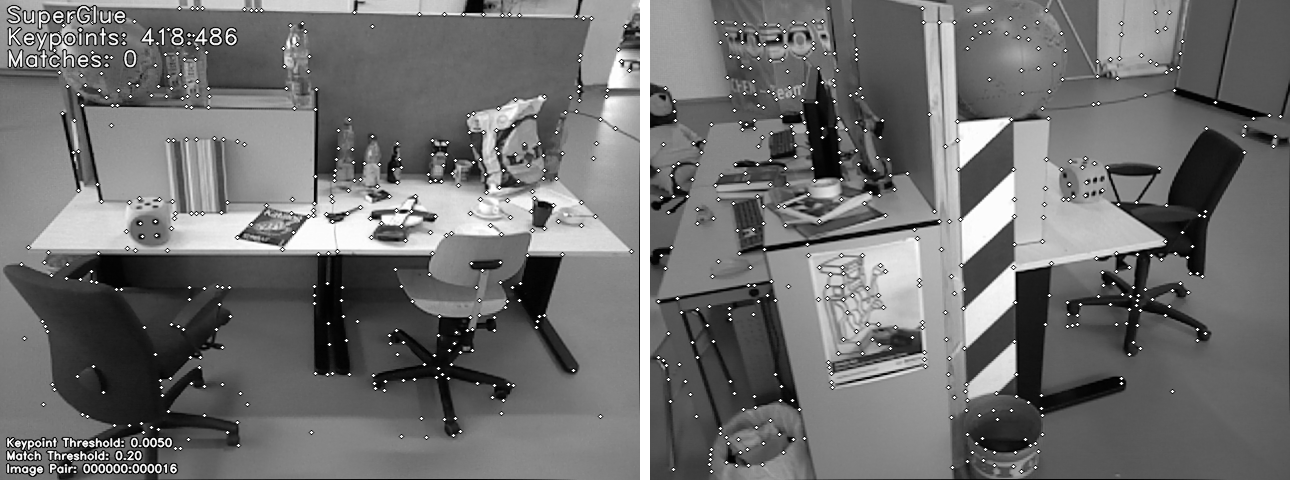

In [6]:
vs.reset()

while True:
    start = time.time()
    frame, ret = vs.next_frame()
    if not ret:
        break

    # Inference
    frame_tensor = frame2tensor(frame, device)
    pred = matching({**last_data, 'image1': frame_tensor})
    end1 = time.time()

    # Vis
    kpts0 = last_data['keypoints0'][0].cpu().numpy()
    kpts1 = pred['keypoints1'][0].cpu().numpy()
    matches = pred['matches0'][0].cpu().numpy()
    confidence = pred['matching_scores0'][0].cpu().numpy()

    valid = matches > -1
    text = ['SuperGlue',
            'Keypoints: {}:{}'.format(len(kpts0), len(kpts1)),
            'Matches: {}'.format(len(kpts0[valid]))]
    small_text = ['Keypoint Threshold: {:.4f}'.format(matching.superpoint.config['keypoint_threshold']),
                  'Match Threshold: {:.2f}'.format(matching.superglue.config['match_threshold']),
                  'Image Pair: {:06}:{:06}'.format(last_image_id, vs.i - 1),]
    out = make_matching_plot_fast(
        last_frame, frame, kpts0, kpts1, kpts0[valid], kpts1[matches[valid]], cm.jet(confidence[valid]), text,
        path=None, show_keypoints=True, small_text=small_text)

    # Compute runtime
    end = time.time()
    net_t = (1./ float(end1 - start))
    total_t = (1./ float(end - start))

    clear_output(wait=True)
    print(small_text[2], text[1], text[2], '(matching: %.2f FPS, total: %.2f FPS)'%(net_t, total_t))
    display(pil.fromarray(out))